<a href="https://colab.research.google.com/github/ApCyb/2023-PLL-lead-lag-pull-in/blob/main/PLL_lead_lag_pull_in.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.optimize import brentq
from datetime import datetime

In [ ]:
def K_vco_ht_function(k, tau_1, tau_2):
    K_vco_ht = 1 / (k * (2 * tau_1 + tau_2 + 2 * math.sqrt(tau_1 * (tau_1 + tau_2))))
    return K_vco_ht

In [ ]:
def K_vco_pt_function(k, tau_1, tau_2):
    K_vco_ht = K_vco_ht_function(k, tau_1, tau_2)
    K_vco_pt_1 = (math.pi * k - 1) / (k * tau_2)
    return max(K_vco_ht, K_vco_pt_1)

In [ ]:
def must_be_greater_than_1_by_pi(k):
    if k <= 1 / math.pi:
        raise ValueError("k must be greater than 1/pi.")

In [ ]:
def omega_ht_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa):
    """
    omega_ht_function calculates frequency for the separatrix cycle

    Parameters:
      k > 1/pi   - Slope
      K_vco > K_vco_ht  - VCO (Voltage-Controlled Oscillator) gain
      tau_1 > 0  - Time constant tau_1
      tau_2 >= 0  - Time constant tau_2

    Returns:
      omega_ht - frequency corresponding to heteroclinic trajectory
    """

    # Threshold K_vco_fn is only defined if tau_2 is nonzero
    K_vco_fn = None
    if tau_2 != 0:
        K_vco_fn = 1 / (k * (2 * tau_1 + tau_2 - 2 * math.sqrt(tau_1 * (tau_1 + tau_2))))

    # Step 1: Calculate s_ht
    if tau_2 == 0 or (K_vco_fn is not None and K_vco < K_vco_fn):
        # Case 1: tau_2 == 0 or K_vco is below the threshold
        numerator = (kappa - eta)**2 + 2 * xi * (kappa - eta) + k
        denominator = (kappa + eta)**2 - 2 * xi * (kappa + eta) + k
        atan_arg = ((xi - eta)**2 + rho**2 - kappa**2) / (2 * rho * kappa)
        exp_term = math.exp((2 * xi / rho) * (math.atan(atan_arg) + math.pi / 2))
        s_ht = (numerator / denominator) * exp_term

    elif K_vco_fn is not None and math.isclose(K_vco, K_vco_fn):
        # Case 2: K_vco equals the threshold
        sqrt_k = math.sqrt(k)
        numerator = kappa - eta + sqrt_k
        denominator = ((kappa + eta - sqrt_k) * math.exp(2 * sqrt_k * kappa / (kappa**2 - (eta - sqrt_k)**2)))**2
        s_ht = (numerator / denominator)

    elif K_vco_fn is not None and K_vco > K_vco_fn:
        # Case 3: K_vco is above the threshold
        term1 = ((kappa - eta + xi)**2 - rho**2) / ((kappa + eta - xi)**2 - rho**2)
        term2_numerator = (kappa + rho)**2 - (xi - eta)**2
        term2_denominator = (kappa - rho)**2 - (xi - eta)**2
        term2 = (term2_numerator / term2_denominator) ** (xi / rho)
        s_ht = term1 * term2
    else:
        raise ValueError("Incorrect parameters")

    # Step 2: Calculate the frequency
    sqrt_s_ht = math.sqrt(s_ht)
    omega_ht = (sqrt_s_ht - 1) / (sqrt_s_ht + 1) * K_vco

    return omega_ht

In [ ]:
def omega_p_function(k, K_vco, tau_1, tau_2):
    """
    OMEGA_P_FORMULA computes the pull-in frequency (omega_p) based on the system's parameters.

    Parameters:
      k > 1/pi   - Slope
      K_vco > 0  - VCO (Voltage-Controlled Oscillator) gain
      tau_1 > 0  - Time constant tau_1
      tau_2 >= 0  - Time constant tau_2

    Returns:
      omega_p - Pull-in frequency based on different conditions
    """

    must_be_greater_than_1_by_pi(k)
    if K_vco <= 0:
        raise ValueError("K_vco must be positive.")
    if tau_1 <= 0:
        raise ValueError("tau_1 must be positive.")
    if tau_2 < 0:
        raise ValueError("tau_2 must be non-negative.")

    # Step 1: Compute the phase difference parameter and threshold values
    K_vco_ht = K_vco_ht_function(k, tau_1, tau_2)

    # Step 2: Compute intermediate parameters for omega_ht and omega_pt
    mu = math.pi * k - 1
    xi = (1 + k * tau_2 * K_vco) / (2 * math.sqrt((tau_1 + tau_2) * K_vco))
    eta = (k * tau_2 * K_vco - mu) / (2 * math.sqrt((tau_1 + tau_2) * K_vco))
    rho = math.sqrt(abs(xi**2 - k))
    kappa = math.sqrt(eta**2 + k * mu)

    if tau_2 == 0:
        # Case 1: When tau_2 is zero
        if K_vco <= K_vco_ht:
            # Sub-case 1a: K_vco is less than or equal to the threshold
            omega_p = K_vco
        else:
            # Sub-case 1b: K_vco exceeds the threshold
            omega_p = omega_ht_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)
    else:
        # Case 2: When tau_2 is non-zero
        k_ht = 2 * (tau_1 + tau_2 + math.sqrt(tau_1 * (tau_1 + tau_2))) / (
               math.pi * (2 * tau_1 + tau_2 + 2 * math.sqrt(tau_1 * (tau_1 + tau_2))))
        K_vco_pt = K_vco_pt_function(k, tau_1, tau_2)

        if k <= k_ht:
            # Sub-case 2a: k is less than or equal to the threshold k_ht
            if K_vco <= K_vco_ht:
                # Sub-case 2a1: K_vco is less than or equal to the threshold
                omega_p = K_vco
            else:
                # Sub-case 2a2: K_vco exceeds the threshold
                omega_p = omega_pt_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)
        else:
            # Sub-case 2b: k exceeds the threshold k_ht
            if K_vco <= K_vco_ht:
                # Sub-case 2b1: K_vco is less than or equal to the threshold
                omega_p = K_vco
            else:
                if K_vco <= K_vco_pt:
                    # Sub-case 2b2: K_vco is within the separatrix range
                    omega_p = omega_ht_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)
                else:
                    # Sub-case 2b3: K_vco exceeds the separatrix range
                    omega_p = omega_pt_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)

    return omega_p


In [ ]:
def omega_pt_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa):
    """
    OMEGA_SS_FORMULA calculates frequency for the semistable cycle

    Parameters:
      k > 1/pi   - Slope
      K_vco > K_vco_pt  - VCO (Voltage-Controlled Oscillator) gain
      tau_1 > 0  - Time constant tau_1
      tau_2 > 0  - Time constant tau_2

    Returns:
      omega_pt - frequency corresponding to the birth of semistable cycle
    """

    # Step 1: Determine the range for z1
    z1_start = kappa + eta
    z1_finish = k * math.sqrt(tau_2 * K_vco)

    # Step 2: Find z1 using a numerical method
    z1_pt = find_z1(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa, z1_start, z1_finish)

    # Step 3: Calculate omega_pt based on the value of z1_pt
    if math.isclose(z1_pt, z1_start):
        # Case 1: z1_pt equals the starting point
        omega_pt = omega_ht_function(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)  # Use separatrix formula
    else:
        # Case 2: General case where z1_pt does not equal the starting point
        z0_pt = z0_function(z1_pt, k, mu, xi, eta)    # Calculate corresponding z0
        numerator = (z0_pt + eta)**2 - kappa**2
        denominator = (z1_pt - eta)**2 - kappa**2
        term1 = numerator / denominator

        term2_1 = (z0_pt + kappa + eta)*(z1_pt + kappa - eta)/(z0_pt - kappa + eta)/(z1_pt - kappa - eta)
        term2 = (term2_1) ** (eta / kappa)
        s_pt = term1 * term2
        omega_pt = (math.sqrt(s_pt) - 1) / (math.sqrt(s_pt) + 1) * K_vco

    return omega_pt

def find_z1(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa, z1_start, z1_finish):
    """FIND_Z1 finds the value of z1 using a recursive or numerical method.

    Parameters:
        k, K_vco, tau_1, tau_2 - System parameters
        z1_start, z1_finish    - Search range for z1

    Returns:
        found_z1 - Value of z1 that satisfies the main_curve condition
    """

    if z1_finish - z1_start < 1e-12:  # since main_curve_z(z1_start) = +inf,
        # we cannot use root finding function at this point
        found_z1 = z1_start  # Return the starting value if range is negligible
    else:
        z1_middle = z1_start + (z1_finish - z1_start)/2  # Midpoint of the range
        middle_val = main_curve(z1_middle, k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa)

        if middle_val < 0:
            # If main_curve is negative, recurse on the lower half
            found_z1 = find_z1(k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa,
                              z1_start, z1_middle)
        else:
            # Otherwise, find the root using brentq
            main_curve_z = lambda z1: main_curve(z1, k, K_vco, tau_1, tau_2,
                                               mu, xi, eta, rho, kappa)

            try:
                found_z1 = brentq(main_curve_z, z1_middle, z1_finish,
                                 rtol=1e-12, xtol=1e-12)
            except ValueError:
                # Fallback if brentq fails
                found_z1 = z1_middle

    return found_z1


def main_curve(z1, k, K_vco, tau_1, tau_2, mu, xi, eta, rho, kappa):
    """MAIN_CURVE calculates the difference between the left-hand and right-hand sides of the main equation.

    Parameters:
        z1 - Variable for the main curve equation
        k, K_vco, tau_1, tau_2 - System parameters

    Returns:
        main_curve_val - Value of the main curve function
    """

    z0 = z0_function(z1, k, mu, xi, eta)

    # Define thresholds for k and K_vco
    k_fn = 2*(tau_1 + tau_2 - math.sqrt(tau_1*(tau_1 + tau_2))) / (math.pi*(2*tau_1 + tau_2 - 2*math.sqrt(tau_1*(tau_1 + tau_2))))
    K_vco_fn = 1/(k*(2*tau_1 + tau_2 - 2*math.sqrt(tau_1*(tau_1 + tau_2))))

    # Calculate the right-hand side of the equation
    if k < k_fn and K_vco < K_vco_fn:
        numerator = z0**2 + 2*xi*z0 + k
        denominator = z1**2 - 2*xi*z1 + k
        atan_term = math.atan(rho/(z0 + xi)) - math.atan((z1 - xi)/rho) + math.pi/2
        right_hand_side = (numerator / denominator) * math.exp(2*xi/rho * atan_term)
    elif k < k_fn and math.isclose(K_vco, K_vco_fn):
        numerator = z0 + math.sqrt(k)
        denominator = z1 - math.sqrt(k)
        exp_term = math.exp(math.sqrt(k)/(z0 + math.sqrt(k)) + math.sqrt(k)/(z1 - math.sqrt(k)))
        right_hand_side = (numerator / denominator * exp_term)**2
    elif (k < k_fn and K_vco > K_vco_fn) or (k >= k_fn):
        term1 = (z0 + xi - rho)*(z0 + xi + rho) / ((z1 - xi + rho)*(z1 - xi - rho))
        term2_numerator = (z0 + xi + rho)*(z1 + rho - xi)
        term2_denominator = (z0 + xi - rho)*(z1 - xi - rho)
        term2 = (term2_numerator / term2_denominator) ** (xi/rho)
        right_hand_side = term1 * term2

    # Calculate the left-hand side of the equation
    numerator = (z0 + eta)**2 - kappa**2
    denominator = (z1 - eta)**2 - kappa**2
    term1 = numerator / denominator

    term2_numerator = (z0 + eta + kappa)*(z1 + kappa - eta)
    term2_denominator = (z0 + eta - kappa)*(z1 - eta - kappa)
    term2 = (term2_numerator / term2_denominator) ** (eta/kappa)

    left_hand_side = term1 * term2

    # Compute the main curve value as the difference
    main_curve_val = left_hand_side - right_hand_side

    return main_curve_val


def z0_function(z1, k, mu, xi, eta):
    """Z0 calculates the value of z0 based on z1 and system parameters.

    Parameters:
        z1, k, mu, xi, eta - Input parameters

    Returns:
        z0_val - Corresponding z0 value
    """

    numerator = (1 + mu)*k*z1 - 2*(mu*xi + eta)*k
    denominator = (1 + mu)*k - 2*(xi - eta)*z1
    z0_val = numerator / denominator

    return z0_val

In [ ]:
def plot_bifurcation_diagram_2parameters(k, a_array):
    """
    Plots bifurcation diagram for slope k > 1/pi and value(s) a = tau_2/(tau_1 + tau_2) < 1

    Parameters:
        k (float): must be greater than 1/pi
        a_array (array-like): value(s) in [0, 1)
    """
    # Input validation
    must_be_greater_than_1_by_pi(k)
    a_array = np.asarray(a_array)
    if np.any(a_array < 0) or np.any(a_array >= 1):
        raise ValueError("a_array must be in [0, 1)")

    # Create x array with same ranges as MATLAB version
    x_ranges = [
        np.arange(0.0001, 10, 0.01),
        np.arange(11, 100, 0.01),
        np.arange(110, 1000, 1),
        np.arange(1100, 10000, 10)
    ]
    x_array = np.concatenate(x_ranges)

    # Setup figure
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    # Loop through each a value
    for a in a_array:
        # Initialize array for pull-in frequency
        y_p = np.zeros(len(x_array))

        # Calculate pull-in frequency for each x value
        for j, x in enumerate(x_array):
            # Parameter transformations:
            tau_1 = 1.0
            tau_2 = a / (1 - a)
            K_vco = x * (1 - a)

            # Compute pull-in frequency using implemented function
            y_p[j] = omega_p_function(k, K_vco, tau_1, tau_2)

        # Normalize pull-in frequency
        y_p_normalized = y_p / ((1 - a) * x_array)

        # Plot normalized pull-in frequency vs x (log scale)
        plt.semilogx(x_array, y_p_normalized, 'black', linewidth=1)

        # Compute and plot heteroclinic threshold (x_ht)
        x_ht = 1 / (k * (2 - a + 2 * math.sqrt(1 - a)))
        plt.semilogx(x_ht, 1, 'kx', markersize=10, markeredgewidth=1)

        # If a ≠ 0, compute and plot pull-in threshold (x_pt)
        if a != 0:
            x_pt = max((math.pi * k - 1) / (a * k), x_ht)
            y_pt = omega_p_function(k, (1 - a) * x_pt, 1, a / (1 - a)) / ((1 - a) * x_pt)
            plt.semilogx(x_pt, y_pt, 'rx', markersize=10, markeredgewidth=1)
    # Format plot
    plt.xlabel(r'$(\tau_1 + \tau_2)K_{\rm vco}$', fontsize=20)
    plt.ylabel(r'$\frac{\omega_p}{K_{\rm vco}}$', fontsize=20)
    plt.xlim(0.4, 10000)
    plt.ylim(0, 1.01)
    plt.xticks([0.01, 0.1, 1, 10, 100, 1000, 10000],
               ['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$'])
    plt.tick_params(axis='both', which='major', labelsize=15)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    prefix2 = "bifurcation_2params"
    filename = f"{prefix2}_{timestamp}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()

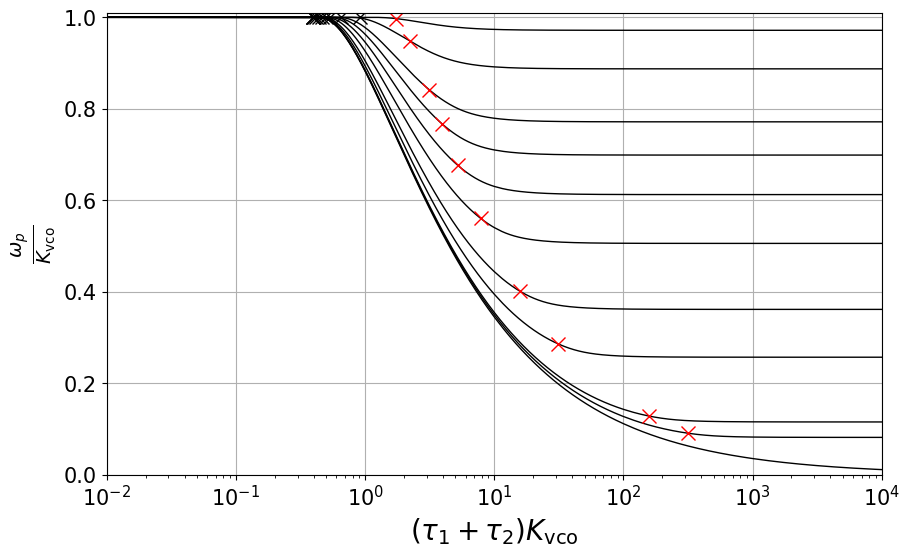

In [ ]:
plot_bifurcation_diagram_2parameters(2/math.pi, [0, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])

In [ ]:
def plot_bifurcation_diagram_3parameters(k, tau_1, tau_2):
    """
    Plots value of normalized pull-in frequency
    for slope k > 1/pi and values tau_1 > 0, tau_2 >= 0

    Parameters:
        k (float): must be greater than 1/pi
        tau_1 (float): must be positive
        tau_2 (float): must be non-negative
    """
    # Input validation
    must_be_greater_than_1_by_pi(k)
    if tau_1 <= 0:
        raise ValueError("tau_1 must be positive")
    if tau_2 < 0:
        raise ValueError("tau_2 must be non-negative")

    # Define the range of K_vco values for modeling
    K_vcos = np.concatenate([
        np.arange(0.1, 10.1, 0.1),
        np.arange(11, 101, 1),
        np.arange(110, 1001, 10),
        np.arange(1100, 10001, 100),
        np.arange(11000, 100001, 1000)
    ])

    n = len(K_vcos)  # Number of points
    omega_p = np.zeros(n)  # Initialize pull-in frequency array

    # Compute omega_p for each K_vco value
    for i in range(n):
        K_vco = K_vcos[i]
        omega_p[i] = omega_p_function(k, K_vco, tau_1, tau_2)

    # Normalize pull-in frequency
    omega_p_normalized = omega_p / K_vcos

    plt.figure(figsize=(10, 6))
    plt.semilogx(K_vcos, omega_p_normalized, 'black', linewidth=1)
    plt.grid(True)

    # Compute and plot the critical point x_ht
    # Critical points K_vco_ht and K_vco_pt
    K_vco_ht = K_vco_ht_function(k, tau_1, tau_2)

    # Plot black cross for K_vco_ht
    plt.semilogx(K_vco_ht, 1, 'kx', markersize=10, markeredgewidth=1)

    if tau_2 != 0:
        # Additional thresholds when tau_2 is non-zero
        K_vco_pt = K_vco_pt_function(k, tau_1, tau_2)
        omega_p_switching_normalized = omega_p_function(k, K_vco_pt, tau_1, tau_2)/K_vco_pt
        # Plot red cross for K_vco_pt
        plt.semilogx(K_vco_pt, omega_p_switching_normalized, 'rx', markersize=10, markeredgewidth=1)

    # Formatting the plot
    plt.xlabel(r'$K_{\rm vco}$', fontsize=20)
    plt.ylabel(r'$\frac{\omega_p}{K_{\rm vco}}$', fontsize=20)
    plt.xlim(min(K_vcos), max(K_vcos))
    plt.ylim(0, 1.1)

    plt.xticks([0.01, 0.1, 1, 10, 100, 1000, 5000],
               [r'$10^{-2}$', r'$10^{-1}$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$5\cdot10^3$'])

    plt.tick_params(axis='both', which='major', labelsize=15)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    prefix3 = "bifurcation_3params"
    filename = f"{prefix3}_{timestamp}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()

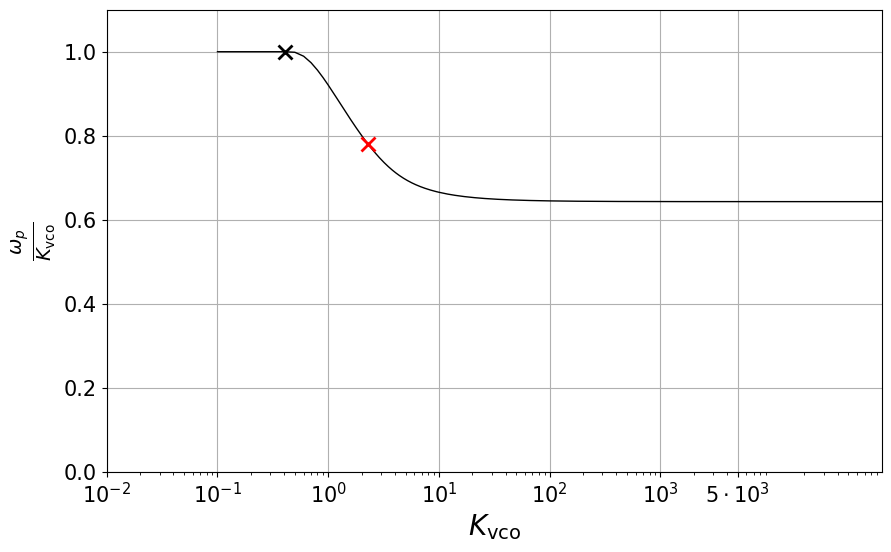

In [ ]:
plot_bifurcation_diagram_3parameters(k=0.5, tau_1=1.0, tau_2=0.5)